In [1]:
import matplotlib.pyplot as plt
import corner as corner
import pandas as pd
import numpy as np
import h5py
import torch
import time
from scipy.special import logsumexp

import sys

sys.path.append('../')
from populations.bbh_models import get_models
import populations.bbh_models as read_models
from populations.utils.flow import NFlow
from populations.Flowsclass_dev import FlowModel
from populations import gw_obs
from populations.bbh_models import read_hdf5

from sample import sample

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


glasflow is using its own internal version of nflows


In [2]:
param = ['mchirp','q', 'chieff', 'z']
no_params = len(param)
channel_label = 'CE'

channel_ids = {'CE':0, 'CHE':1,'GC':2,'NSC':3, 'SMT':4}
channel_id = channel_ids[channel_label] #will be 0, 1, 2, 3, or 4
channel_samples = [4e6,864124,896611,582961, 4e6]
no_binaries = int(channel_samples[channel_id])
batch_size = 10000
total_hps=4

models_path ='/Users/stormcolloms/Documents/PhD/Project_work/OneChannel_Flows/models_reduced.hdf5'
popsynth_outputs = read_hdf5(models_path, channel_label) # read all data from hdf5 file

models_dict = dict.fromkeys(popsynth_outputs.keys())
weights_dict = dict.fromkeys(popsynth_outputs.keys())


for key in popsynth_outputs.keys():
    models_dict[key] = popsynth_outputs[key][param]
    weights_dict[key]= popsynth_outputs[key]['weight']

In [5]:
params = ['mchirp','q', 'chieff', 'z']
chi_b = [0.0,0.1,0.2,0.5]
alpha = [0.2,0.5,1.,2.,5.]
file_path='/Users/stormcolloms/Documents/PhD/Project_work/OneChannel_Flows/models_reduced.hdf5'
gw_path = '/Users/stormcolloms/Documents/PhD/Project_work/AMAZE_model_selection/gw_events'
observations, obsdata, p_theta, events = gw_obs.generate_observations(params, gw_path, \
                                            100, 'posteriors', None)

model_names, flow = read_models.get_models(file_path, ['CE'], params, use_flows=True, device='cpu', no_bins=[5])
_, KDE = read_models.get_models(file_path, ['CE'], params, use_flows=False, device='cpu', normalize=True)

#inputs: x, data, pop_models, submodels_dict, channels, use_flows
hyperparams = list(set([x.split('/', 1)[1] for x in model_names]))
Nhyper = np.max([len(x.split('/')) for x in hyperparams])
channels = sorted(list(set([x.split('/')[0] for x in model_names])))

# construct dict that relates submodels to their index number
submodels_dict = {} #dummy index dict keys:0,1,2,3, items: particular models
ctr=0 #associates with either chi_b or alpha (0 or 1)
while ctr < Nhyper:
    submodels_dict[ctr] = {}
    hyper_set = sorted(list(set([x.split('/')[ctr] for x in hyperparams])))
    for idx, model in enumerate(hyper_set): #idx associates with 0,1,2,3,(4) keys
        submodels_dict[ctr][idx] = model
    ctr += 1

100%|██████████| 20/20 [00:08<00:00,  2.33it/s]


In [6]:
flow_path="/Users/stormcolloms/Documents/PhD/Project_work/AMAZE_model_selection/rns/flows_271023/flows_271023/flow_models/"
flow['CE'].load_model(flow_path, 'CE')

[ -0.50543649 100.          13.34709027   1.          14.03557119
  10.        ]


In [7]:
mchirps = np.linspace(0.1,99.9,100)
sample = np.zeros((100,4))
conds = np.reshape((np.tile([0.5,0.2],np.shape(sample)[0])),(1,-1,2))

for i, m in enumerate(mchirps):
    sample[i] = np.asarray([m, 0.8,0.1,0.1])

sample = np.reshape(sample, (1,-1,4))

mapped_sample = flow['CE'].map_obs(sample)

p_mchirp = np.zeros((4,5,np.shape(sample)[1]))
for chibid, xb in enumerate(chi_b):
    for alphaid, a  in enumerate(alpha):
        conds = np.reshape((np.tile([xb,a],np.shape(sample)[1])),(1,-1,2))
        p_mchirp[chibid, alphaid] = flow['CE'].flow.get_logprob(sample, mapped_sample, flow['CE'].mappings, conds)

In [8]:
mchirps_kde = np.linspace(0.1,99.9,100)
sample = np.zeros((100,4))
conds = np.reshape((np.tile([0.5,0.2],np.shape(sample)[0])),(1,-1,2))

for i, m in enumerate(mchirps_kde):
    sample[i] = np.asarray([m, 0.8,0.1,0.1])

sample = np.reshape(sample, (1,-1,4))

p_mchirp_kde = np.zeros((4,5,np.shape(sample)[1]))

for chibid, xb in enumerate(chi_b):
    for alphaid, a  in enumerate(alpha):
        conds = np.reshape((np.tile([xb,a],np.shape(sample)[1])),(1,-1,2))
        p_mchirp_kde[chibid, alphaid] = KDE['CE'][submodels_dict[0][chibid]][submodels_dict[1][alphaid]].pdf(sample[0])

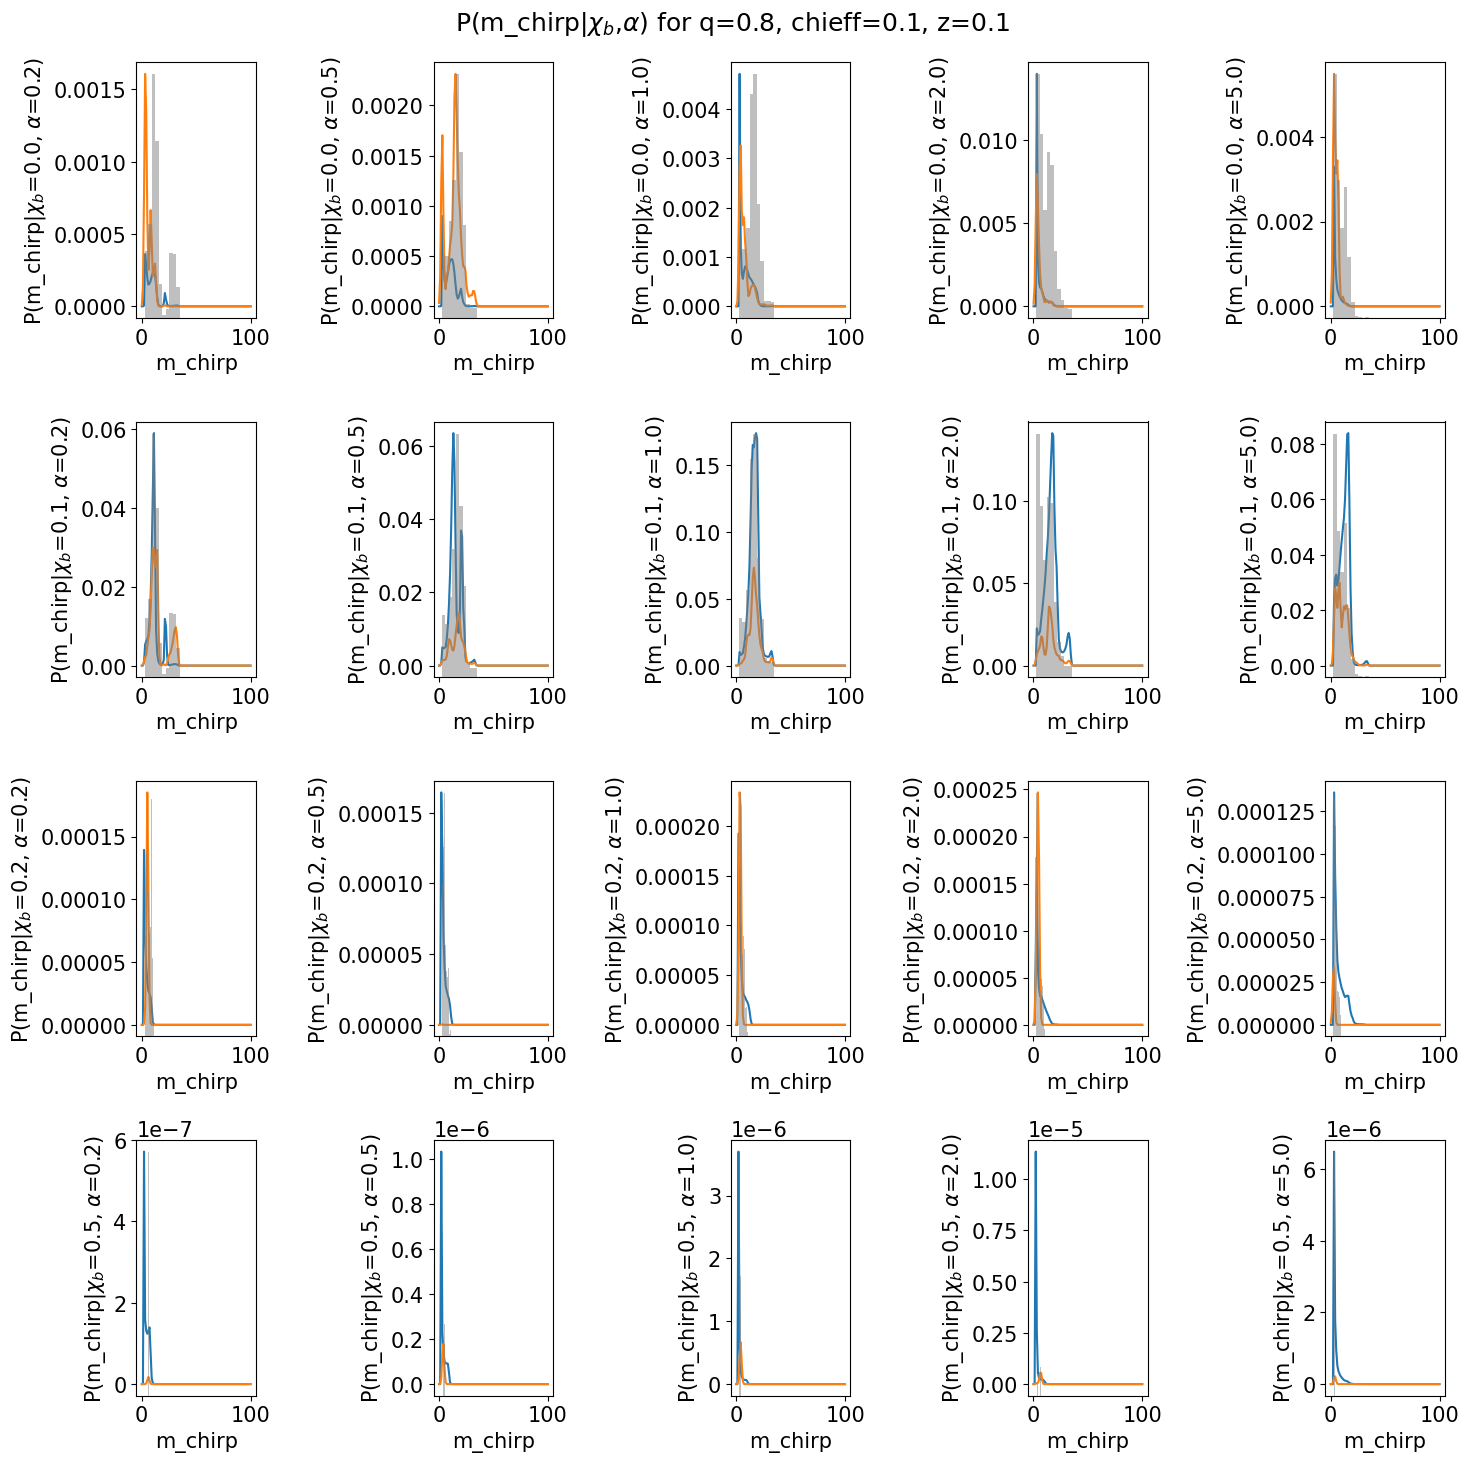

In [9]:
plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams.update({'font.size': 15})
fig_mchirp, ax = plt.subplots(4,5)

for chibid, xb in enumerate(chi_b):
    for alphaid, a  in enumerate(alpha):
        ax[chibid,alphaid].plot(mchirps, np.reshape(np.exp(p_mchirp[chibid,alphaid]), -1))
        ax[chibid,alphaid].plot(mchirps_kde, np.reshape((p_mchirp_kde[chibid,alphaid]), -1))

        #plot histogram of samples around this point q=0.8,chieff=0.1,z=0.1
        bin_width = 0.05
        qs= models_dict[(chibid,alphaid)][:]['q']
        chieffs = models_dict[(chibid,alphaid)][:]['chieff']
        zs = models_dict[(chibid,alphaid)][:]['z']
        bin_q = np.logical_and(qs>0.8 - bin_width, qs < 0.8 + bin_width)
        bin_chieff = np.logical_and(chieffs>0.1 - 2*bin_width,  chieffs< 0.1 + 2*bin_width)
        bin_z = np.logical_and(zs>0.1 - 10*bin_width, zs < 0.1 + 10*bin_width)
        bin_conditions = np.logical_and(np.logical_and(bin_q, bin_chieff), bin_z)

        secax = ax[chibid,alphaid].twinx()
        secax.hist(models_dict[(chibid,alphaid)][bin_conditions]['mchirp'], weights=weights_dict[(chibid,alphaid)][bin_conditions], color='grey', alpha=0.5, density=True)
        secax.axis('off')

        ax[chibid,alphaid].set_xlabel(fr'm_chirp')
        ax[chibid,alphaid].set_ylabel(fr'P(m_chirp|$\chi_b$={xb}, $\alpha$={a})')
        #ax[chibid,alphaid].set_ylim(-50,1)
        #ax[chi_b_id,alpha_id].legend()
fig_mchirp.suptitle(fr'P(m_chirp|$\chi_b$,$\alpha$) for q=0.8, chieff=0.1, z=0.1')
fig_mchirp.tight_layout(pad=1.3)

### different set of (q,chieff,z)

In [10]:
mchirps = np.linspace(0.1,99.9,100)
sample = np.zeros((100,4))
conds = np.reshape((np.tile([0.5,0.2],np.shape(sample)[0])),(1,-1,2))

for i, m in enumerate(mchirps):
    sample[i] = np.asarray([m, 0.3,0.0,0.9])

sample = np.reshape(sample, (1,-1,4))

mapped_sample = flow['CE'].map_obs(sample)

p_mchirp_flow = np.zeros((4,5,np.shape(sample)[1]))

for chibid, xb in enumerate(chi_b):
    for alphaid, a  in enumerate(alpha):
        conds = np.reshape((np.tile([xb,a],np.shape(sample)[1])),(1,-1,2))
        p_mchirp_flow[chibid, alphaid] = flow['CE'].flow.get_logprob(sample, mapped_sample, flow['CE'].mappings, conds)

In [11]:
mchirps_kde = np.linspace(0.1,99.9,100)
sample = np.zeros((100,4))
conds = np.reshape((np.tile([0.5,0.2],np.shape(sample)[0])),(1,-1,2))

for i, m in enumerate(mchirps_kde):
    sample[i] = np.asarray([m, 0.3,0.0,0.9])

sample = np.reshape(sample, (1,-1,4))

p_mchirp_kde = np.zeros((4,5,np.shape(sample)[1]))

for chibid, xb in enumerate(chi_b):
    for alphaid, a  in enumerate(alpha):
        conds = np.reshape((np.tile([xb,a],np.shape(sample)[1])),(1,-1,2))
        p_mchirp_kde[chibid, alphaid] = KDE['CE'][submodels_dict[0][chibid]][submodels_dict[1][alphaid]].pdf(sample[0])

/Users/stormcolloms/opt/anaconda3/envs/amaze/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


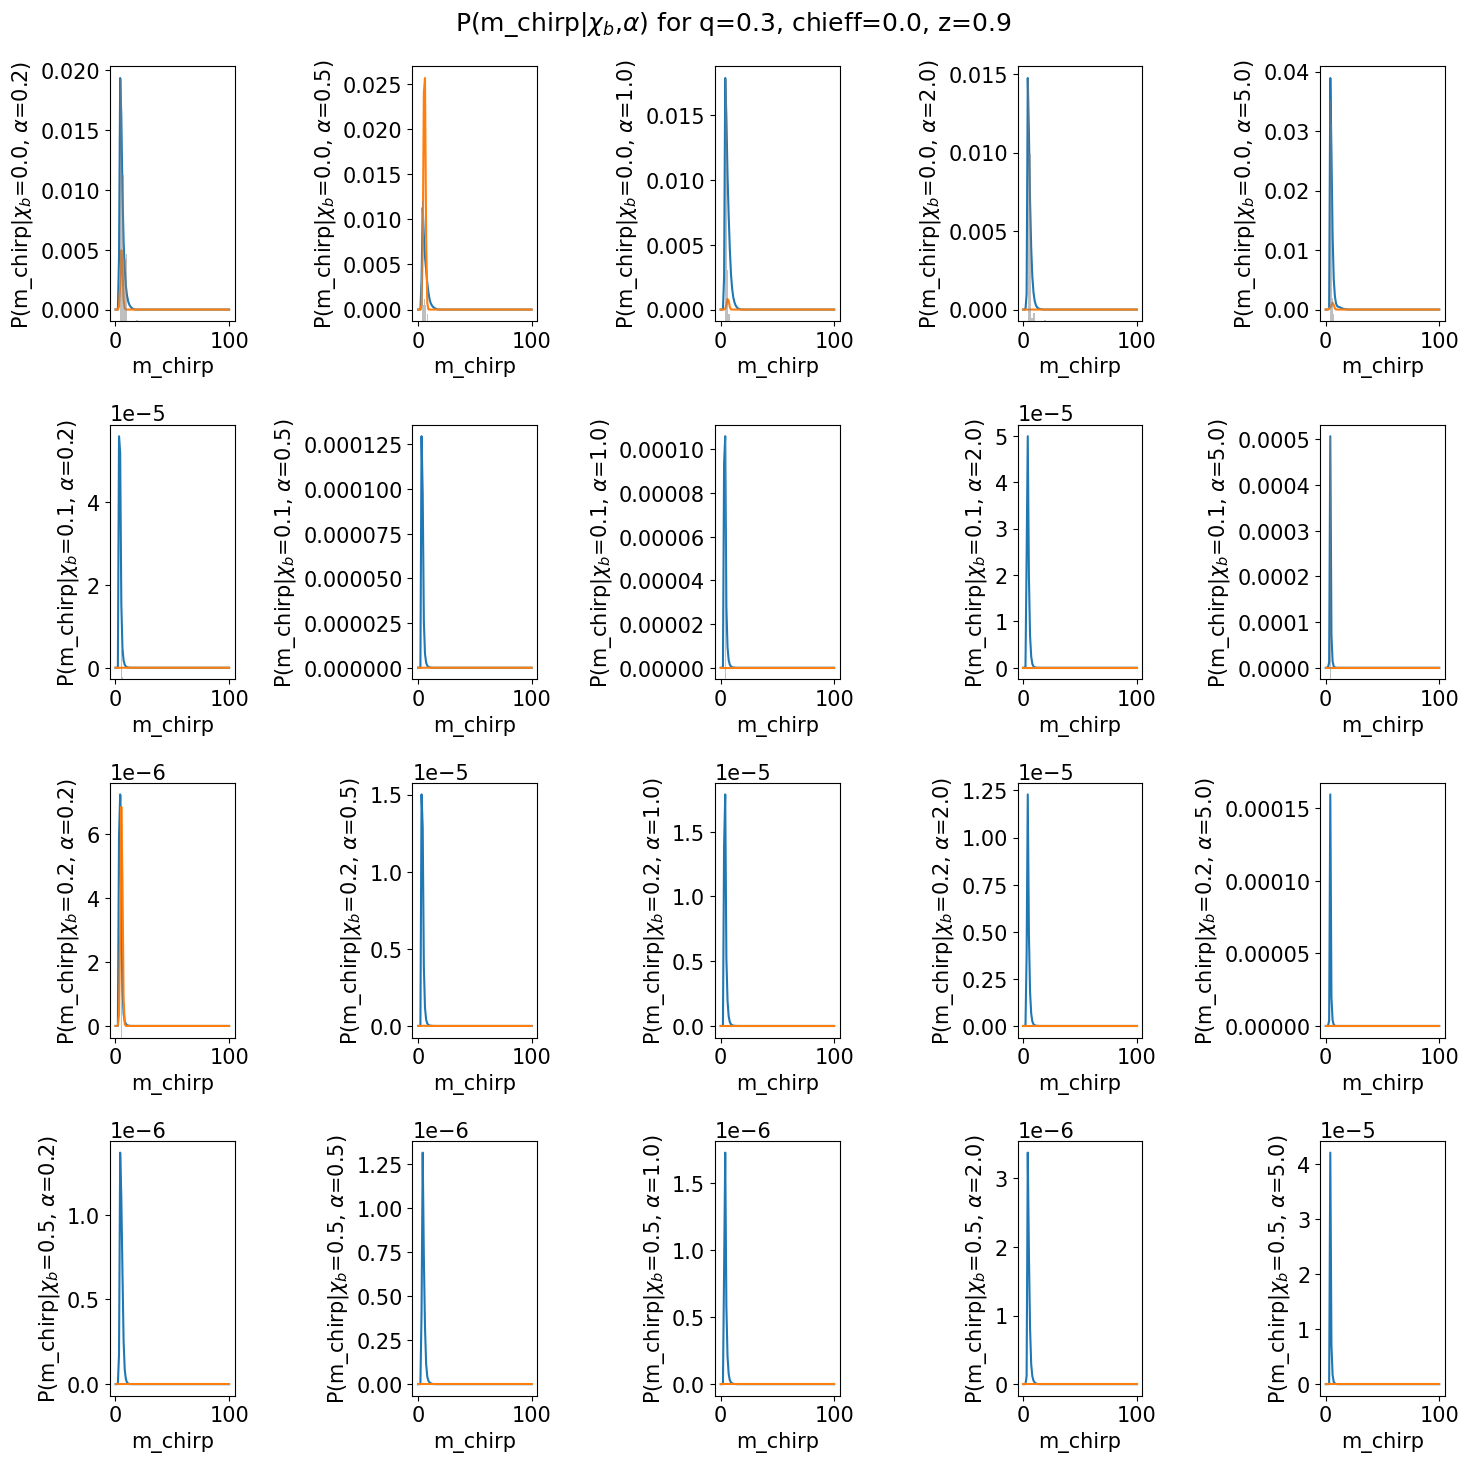

In [12]:
plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams.update({'font.size': 15})
fig_mchirp, ax = plt.subplots(4,5)

for chibid, xb in enumerate(chi_b):
    for alphaid, a  in enumerate(alpha):
        ax[chibid,alphaid].plot(mchirps, np.reshape(np.exp(p_mchirp_flow[chibid,alphaid]), -1))
        ax[chibid,alphaid].plot(mchirps_kde, np.reshape((p_mchirp_kde[chibid,alphaid]), -1))


        bin_width = 0.05
        qs= models_dict[(chibid,alphaid)][:]['q']
        chieffs = models_dict[(chibid,alphaid)][:]['chieff']
        zs = models_dict[(chibid,alphaid)][:]['z']
        bin_q = np.logical_and(qs>0.3 - bin_width, qs < 0.3 + bin_width)
        bin_chieff = np.logical_and(chieffs>0.0 - 2*bin_width,  chieffs< 0.0 + 2*bin_width)
        bin_z = np.logical_and(zs>0.9 - 10*bin_width, zs < 0.9 + 10*bin_width)
        bin_conditions = np.logical_and(np.logical_and(bin_q, bin_chieff), bin_z)

        secax = ax[chibid,alphaid].twinx()
        secax.hist(models_dict[(chibid,alphaid)][bin_conditions]['mchirp'], weights=weights_dict[(chibid,alphaid)][bin_conditions], color='grey', alpha=0.5, density=True)
        secax.axis('off')
        ax[chibid,alphaid].set_xlabel(fr'm_chirp')
        ax[chibid,alphaid].set_ylabel(fr'P(m_chirp|$\chi_b$={xb}, $\alpha$={a})')
        #ax[chibid,alphaid].set_ylim(-50,1)
        #ax[chi_b_id,alpha_id].legend()
fig_mchirp.suptitle(fr'P(m_chirp|$\chi_b$,$\alpha$) for q=0.3, chieff=0.0, z=0.9')
fig_mchirp.tight_layout(pad=1.3)


## And for q

In [13]:
qs = np.linspace(0.01,0.999,100)
sample = np.zeros((100,4))
conds = np.reshape((np.tile([0.5,0.2],np.shape(sample)[0])),(1,-1,2))

for i, q in enumerate(qs):
    sample[i] = np.asarray([30., q,0.1,0.1])

sample = np.reshape(sample, (1,-1,4))

mapped_sample = flow['CE'].map_obs(sample)

p_q_flow = np.zeros((4,5,np.shape(sample)[1]))
for chibid, xb in enumerate(chi_b):
    for alphaid, a  in enumerate(alpha):
        conds = np.reshape((np.tile([xb,a],np.shape(sample)[1])),(1,-1,2))
        p_q_flow[chibid, alphaid] = flow['CE'].flow.get_logprob(sample, mapped_sample, flow['CE'].mappings, conds)

In [14]:
qs_kde = np.linspace(0.01,0.999,100)
sample = np.zeros((100,4))
conds = np.reshape((np.tile([0.5,0.2],np.shape(sample)[0])),(1,-1,2))

for i, q in enumerate(qs_kde):
    sample[i] = np.asarray([30., q,0.1,0.1])

sample = np.reshape(sample, (1,-1,4))

p_q_kde = np.zeros((4,5,np.shape(sample)[1]))

for chibid, xb in enumerate(chi_b):
    for alphaid, a  in enumerate(alpha):
        conds = np.reshape((np.tile([xb,a],np.shape(sample)[1])),(1,-1,2))
        p_q_kde[chibid, alphaid] = KDE['CE'][submodels_dict[0][chibid]][submodels_dict[1][alphaid]].pdf(sample[0])

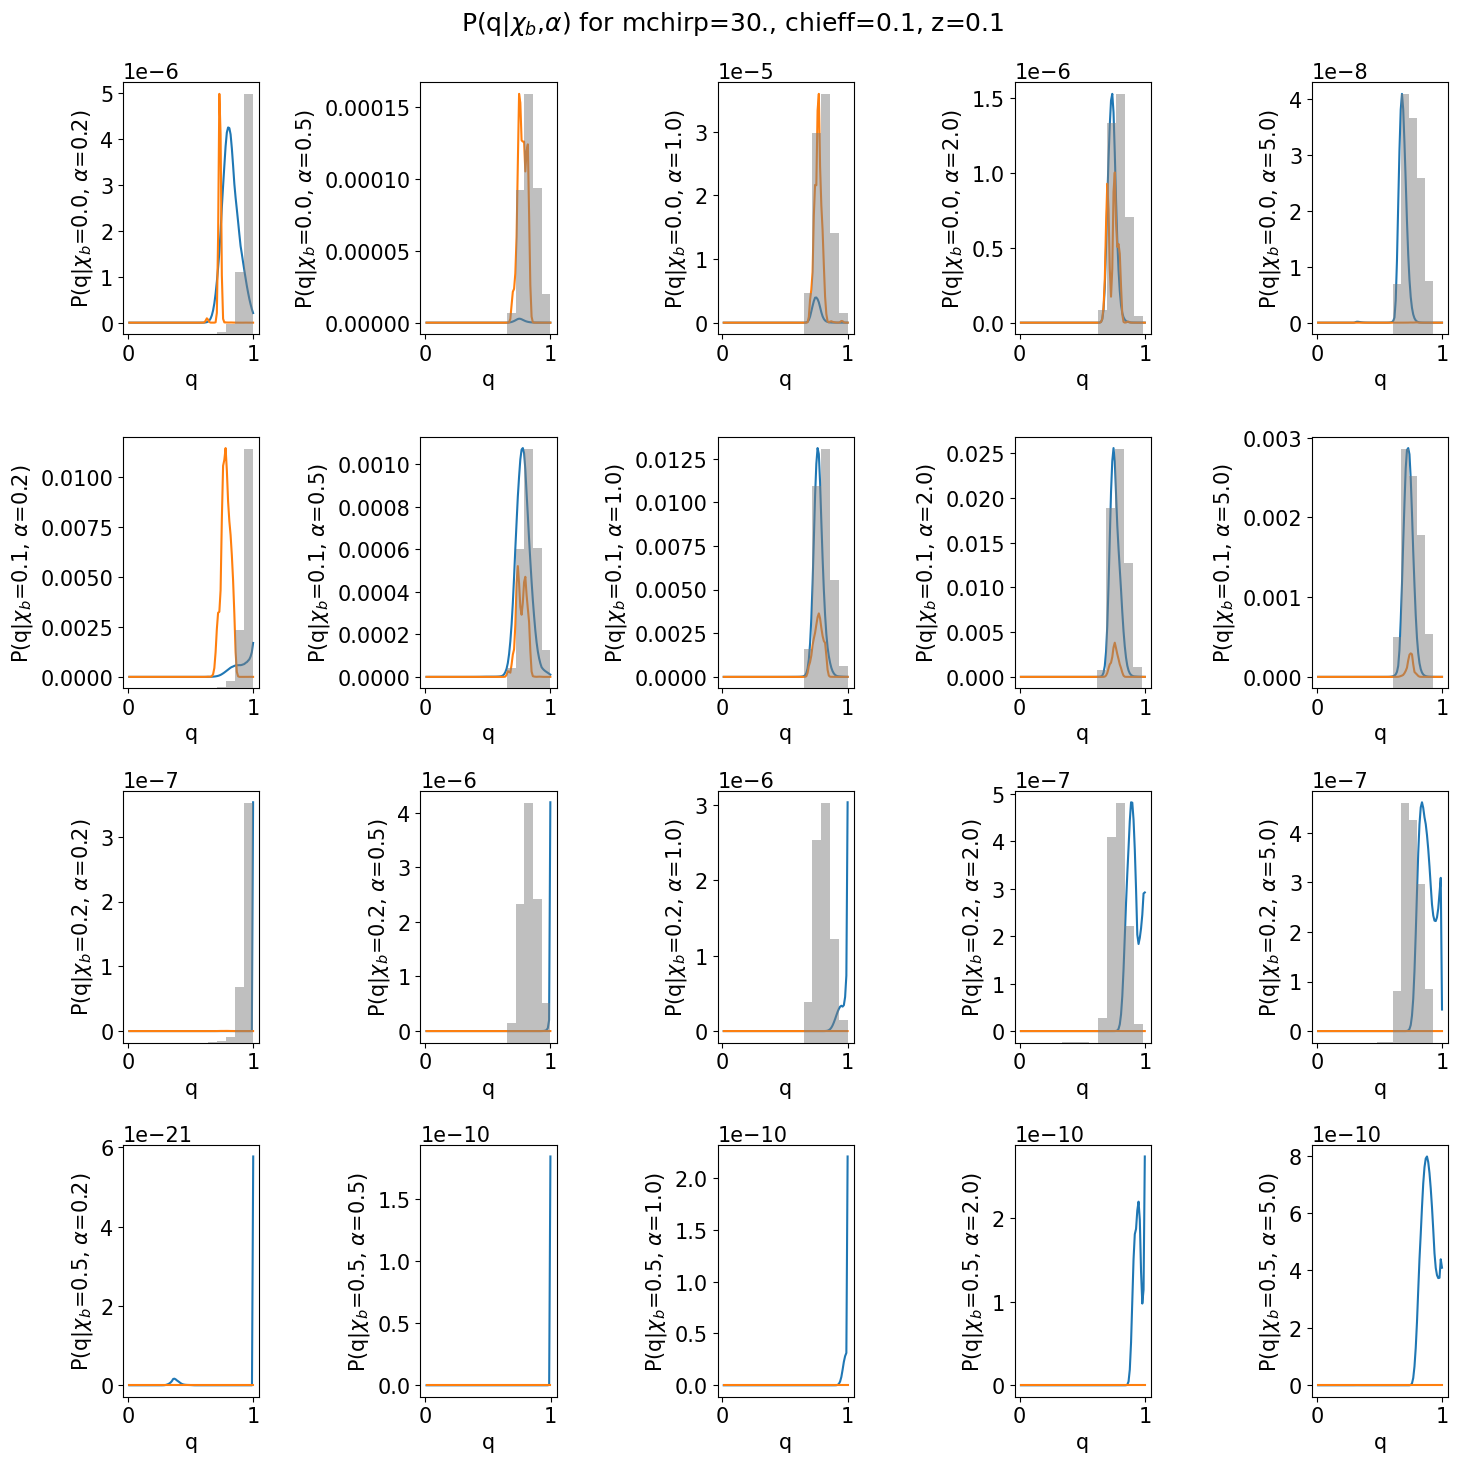

In [15]:
plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams.update({'font.size': 15})
fig_mchirp, ax = plt.subplots(4,5)

for chibid, xb in enumerate(chi_b):
    for alphaid, a  in enumerate(alpha):
        ax[chibid,alphaid].plot(qs, np.reshape(np.exp(p_q_flow[chibid,alphaid]), -1))
        ax[chibid,alphaid].plot(qs_kde, np.reshape((p_q_kde[chibid,alphaid]), -1))
        bin_width = 0.15
        mchirps= models_dict[(chibid,alphaid)][:]['mchirp']
        chieffs = models_dict[(chibid,alphaid)][:]['chieff']
        zs = models_dict[(chibid,alphaid)][:]['z']
        bin_mchirp = np.logical_and(mchirps>30. - 100*bin_width, mchirps < 10. + 100*bin_width)
        bin_chieff = np.logical_and(chieffs>0.1 - 2*bin_width,  chieffs< 0.1 + 2*bin_width)
        bin_z = np.logical_and(zs>0.1 - 10*bin_width, zs < 0.1 + 10*bin_width)
        bin_conditions = np.logical_and(np.logical_and(bin_mchirp, bin_chieff), bin_z)

        secax = ax[chibid,alphaid].twinx()
        secax.hist(models_dict[(chibid,alphaid)][bin_conditions]['q'], weights=weights_dict[(chibid,alphaid)][bin_conditions], color='grey', alpha=0.5, density=True)
        secax.axis('off')
        #ax[chibid,alphaid].set_ylim(-50,10)
        ax[chibid,alphaid].set_xlabel(fr'q')
        ax[chibid,alphaid].set_ylabel(fr'P(q|$\chi_b$={xb}, $\alpha$={a})')
        #ax[chi_b_id,alpha_id].legend()
fig_mchirp.suptitle(fr'P(q|$\chi_b$,$\alpha$) for mchirp=30., chieff=0.1, z=0.1')
fig_mchirp.tight_layout(pad=1.3)
